# Competitive Analysis of the Entry-Level Luxury Car Market in the USA
## Prepared for: JD Power and Associates

# Table of Contents

1. [Introduction](#Introduction)
   - [Objective](#Objective)
   - [Scope](#Scope)
   - [Note](#Note)
2. [Data Collection](#Data-Collection)
3. [Analysis and Findings](#Analysis-and-Findings)
   - [Task A: Zipf’s Law Verification](#Task-A:-Zipf's-Law-Verification)
     - [Visual Inspection](#Visual-Inspection)
     - [Econometric Analysis](#Econometric-Analysis)
   - [Task B: Top Brand Analysis](#Task-B:-Top-Brand-Analysis)
     - [Identifying the Top 10 Brands](#Identifying-the-Top-10-Brands)
     - [Frequency Table of Top 10 Brands](#Frequency-Table-of-Top-10-Brands)
   - [Task C: Lift Values Analysis](#Task-C:-Lift-Values-Analysis)
     - [Calculation of Lift Values](#Calculation-of-Lift-Values)
     - [Lift Values Table](#Lift-Values-Table)
   - [Task D: Multi-Dimensional Scaling (MDS) Map](#Task-D:-Multi-Dimensional-Scaling-(MDS)-Map)
   - [Task E: Insights from Tasks C and D](#Task-E:-Insights-from-Tasks-C-and-D)
     - [Key Findings](#Key-Findings)
     - [Business Suggestions](#Business-Suggestions)
   - [Task F: Attributes Analysis](#Task-F:-Attributes-Analysis)
     - [Identification of Top 5 Attributes](#Identification-of-Top-5-Attributes)
     - [Brand-Attribute Association](#Brand-Attribute-Association)
   - [Task G: Advice Based on Task F](#Task-G:-Advice-Based-on-Task-F)
   - [Task H: Aspirational Brand Analysis](#Task-H:-Aspirational-Brand-Analysis)
     - [Approach](#Approach)
     - [Findings](#Findings:)
     - [Business Implications](#Business-Implications:)

## Introduction

In a rapidly evolving automotive market, understanding consumer preferences and the perceptual landscape of different car brands can offer a competitive edge to businesses. Leveraging the wealth of data available in online forums, where enthusiasts and consumers alike share their candid opinions and experiences, can be a goldmine of insights for companies. Recognizing this potential, JD Power and Associates has commissioned this study to delve deep into the consumer conversations circulating in the entry-level luxury car market in the USA.

### Objective

The primary objective of this assignment is to analyze discussions from one of the most prominent car forums, Edmunds.com, to glean insights into the perceptions and preferences revolving around various brands in the entry-level luxury car segment. Through a meticulous analysis of social media conversations, we aim to offer advice and insights that can help JD Power and Associates steer their strategies effectively.

### Scope

In the pursuit of achieving this objective, our approach will encompass the following tasks:

- **Data Acquisition**: Developing a Python scraper to fetch around 5000 posts from the Entry Level Luxury forum on Edmunds.com, capturing the natural and unfiltered opinions of consumers.

- **Data Analysis**: Employing various analytics techniques to analyze the data, which includes verifying Zipf's law, identifying top brands through frequency counts, and computing lift ratios for associations between the top brands.

- **Visualization**: Creating a multi-dimensional scaling (MDS) map to visually represent the brand associations.

- **Attribute Analysis**: Identifying the most frequently mentioned attributes or features of cars in the discussions and understanding their strong associations with the top five brands.

- **Aspiration Analysis**: Determining the most aspirational brand in the dataset, i.e., the brand that people most desire to own or purchase.

### Note

While delving into the analysis, we operate under the assumption that all sentiments in the scraped messages are positive, and we will not be conducting sentiment analysis for this assignment.

In [4]:
# Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sklearn.datasets as dt
import seaborn as sns
import statsmodels.api as sm

from bs4 import BeautifulSoup
from collections import Counter
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from statistics import mean

from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import csv
import time
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Collection

We scraped the first 5000 comments from the 'entry-level-luxury-performance-sedans' discussion on Edmunds using BeautifulSoup.

In [2]:
BASE_URL = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"
}

def get_messages_from_page(url):
    response = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(response.content, "html.parser")

    messages = soup.select(".Message.userContent")
    dates = [msg.find_previous("time")["datetime"] for msg in messages]

    filtered_messages = []
    for date, msg in zip(dates, messages):
        message_text = msg.text.strip()
        if message_text:
            filtered_messages.append({"date": date, "message": message_text})

    return filtered_messages

def main():
    all_messages = []
    page_number = 1
    TARGET_POSTS = 5000  # Number of posts we want to scrape
    
    while len(all_messages) < TARGET_POSTS:
        # Construct the URL based on the page number
        if page_number == 1:
            current_url = BASE_URL
        else:
            current_url = f"{BASE_URL}/p{page_number}"
        
        current_messages = get_messages_from_page(current_url)
        
        # If no messages are found on the current page, break the loop
        if not current_messages:
            break
        
        # Exclude the first post only on the first page
        if page_number == 1:
            current_messages = current_messages[1:]

        all_messages.extend(current_messages)
        
        # Introduce a 2-second pause before fetching the next page
        # time.sleep(2)
        
        page_number += 1

    # If we gather more than 5000 messages due to the last page, trim the list
    all_messages = all_messages[:TARGET_POSTS]

    with open("/Users/sam/Desktop/UT_MSBA/Fall/MIS 284N_UDA/Assignment_1/edmunds_messages.csv", "w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["date", "message"])
        writer.writeheader()
        for message in all_messages:
            writer.writerow(message)

if __name__ == "__main__":
    main()


In [5]:
# Load the dataset into a DataFrame
file_path = "/Users/sam/Desktop/UT_MSBA/Fall/MIS 284N_UDA/Assignment_1/edmunds_messages.csv"
comments = pd.read_csv(file_path)
# Display the first few rows of the DataFrame to understand its structure
comments.head()

,date,message
0,2002-03-25T05:54:02+00:00,I personally think that with a few tweaks the ...
1,2002-03-25T07:06:29+00:00,I am debating a new purchase and these two are...
2,2002-03-25T17:02:27+00:00,"Great handling, RWD, excellent engine and the ..."
3,2002-03-25T23:04:37+00:00,And no manual tranny. That may not matter to y...
4,2002-03-26T00:44:13+00:00,One beauty of BMW 3 Series is that there are s...


In [6]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     5000 non-null   object
 1   message  5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [7]:
#Tokenize each message
def tokenize_message(message):
    # Tokenize the message using NLTK's word_tokenize
    tokens = word_tokenize(message)
    return tokens

comments['tokens'] = comments['message'].map(tokenize_message)
comments.head()

,date,message,tokens
0,2002-03-25T05:54:02+00:00,I personally think that with a few tweaks the ...,"[I, personally, think, that, with, a, few, twe..."
1,2002-03-25T07:06:29+00:00,I am debating a new purchase and these two are...,"[I, am, debating, a, new, purchase, and, these..."
2,2002-03-25T17:02:27+00:00,"Great handling, RWD, excellent engine and the ...","[Great, handling, ,, RWD, ,, excellent, engine..."
3,2002-03-25T23:04:37+00:00,And no manual tranny. That may not matter to y...,"[And, no, manual, tranny, ., That, may, not, m..."
4,2002-03-26T00:44:13+00:00,One beauty of BMW 3 Series is that there are s...,"[One, beauty, of, BMW, 3, Series, is, that, th..."


In [8]:
#creating list of all the words with their frequency
word_list=[]
def f(token_list):
    for i in token_list:
        word_list.append(i.lower())

comments['tokens'].map(f)

#word frequency
pd.Series(word_list).value_counts()

#exporting the word frequency to csv
pd.Series(word_list).value_counts().to_csv('word_frequency.csv')

In [9]:
words=pd.read_csv('word_frequency.csv')
words.columns = ['word','count']

#rank the words based on frequency
words['Rank']=words['count'].rank(ascending=False,method='min')

In [10]:
df = words[:100].copy()
df.head()

,word,count,Rank
0,the,26550,1.0
1,.,22065,2.0
2,",",19536,3.0
3,a,12094,4.0
4,i,12041,5.0


## Analysis and Findings

### Task A: Zipf’s Law Verification

In this task, we set out to investigate whether the scraped comments data adheres to Zipf's law. Our examination involved a two-pronged approach: a visual inspection through log-log plots and an econometric analysis involving the computation and analysis of a derived parameter, $theta$. In the end, we fit into linear regression to test if the slope is close to -1.

In [11]:
# Extract ranks and frequencies
ranks = df['Rank'].values
frequencies = df['count'].values
# Define parameters for the Zipf's canonical line
C = frequencies[-1]*100 # Set C as the frequency of the most common word
# Generate expected frequencies based on the Zipf's canonical line
expected_frequencies = [C / rank for rank in ranks]

#### Visual Inspection

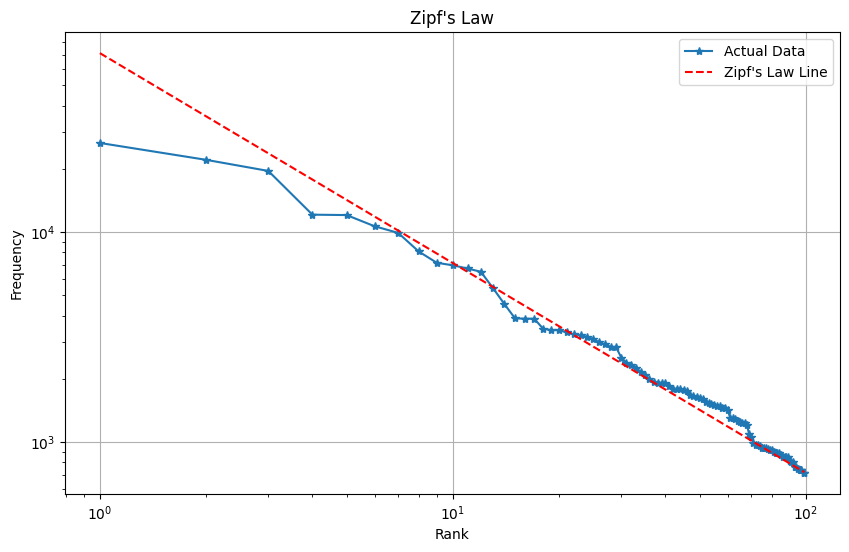

In [12]:
# Plot the results on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, marker='*', label='Actual Data')
plt.loglog(ranks, expected_frequencies, linestyle='--', color='red', label="Zipf's Law Line")
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title("Zipf's Law")
plt.grid(True)
plt.legend()
plt.show()

#### Econometric Analysis

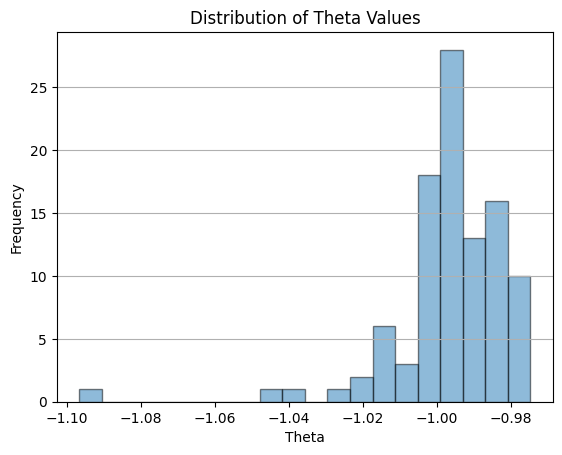

In [13]:
#Proving Zipf's law 
#lnr = theta * ln(xr/n*xn)
#theta = ln(xr/n*xn)/lnr

f = list(df['count'].values)
r = np.arange(1, len(f) + 1)
xn = min(f)
n = len(f)

#test if theta = -1
theta_list = []
for xr, r in enumerate(frequencies):
    if r != 1:
        theta_list.append(np.log((xr+1)/(n*xn))/np.log(r))
        
# Display the first few thetas and calculate the mean theta
mean_theta = np.mean(theta_list)
median_theta = np.median(theta_list)

# Calculate the standard deviation of theta values and the percentage of theta values within one standard deviation of the mean
theta_std = np.std(theta_list)
up_range = mean_theta + theta_std
low_range = mean_theta - theta_std

within_one_std = np.where((np.array(theta_list) <= up_range) & (np.array(theta_list) >= low_range))
percentage_within_one_std = (len(within_one_std[0]) / len(theta_list)) * 100

# Plot a histogram of the theta values
plt.hist(theta_list, bins=20, edgecolor='black', alpha=0.5)
plt.title('Distribution of Theta Values')
plt.xlabel('Theta')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()


In [14]:
print(f"Mean of θ values: {mean_theta}")
print(f"Median of θ values: {median_theta}")
print(f"Standard deviation of θ values: {theta_std}")
print(f"Percentage of θ values within one standard deviation of the mean: {percentage_within_one_std:.2f}%")

Mean of θ values: -0.9964301738386133
Median of θ values: -0.9947532168865159
Standard deviation of θ values: 0.016088779591537088
Percentage of θ values within one standard deviation of the mean: 83.00%


Mean θ value is closed to the theoretical value of -1 predicted by Zipf's law, a substantial 83% of θ values lie within one standard deviation of the mean. Moreover, the median is close to -1, showing a significant adherence to the law. In conclusion, while not 100% perfectly aligning with Zipf's law, the dataset demonstrates a notable tendency towards the distribution anticipated by the law, indicating prevalent natural linguistic patterns in the discussions analyzed.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     5971.
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           1.27e-89
Time:                        22:33:14   Log-Likelihood:                 83.105
No. Observations:                 100   AIC:                            -162.2
Df Residuals:                      98   BIC:                            -157.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7950      0.043    249.438      0.0

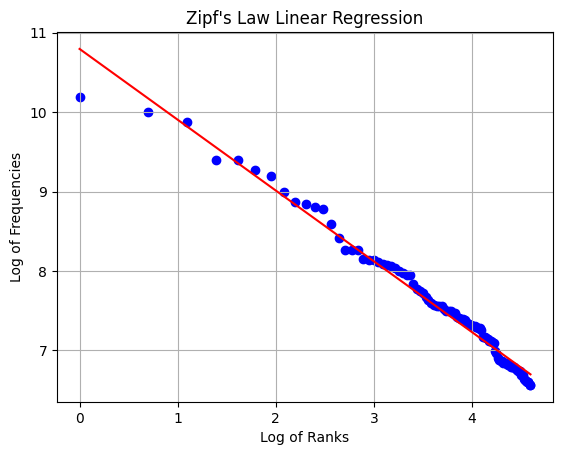

In [15]:
# Transform data to log scale
log_frequencies = np.log(frequencies)
log_ranks = np.log(ranks)

# Add a constant to get an intercept
log_ranks_sm = sm.add_constant(log_ranks)

# Create a model
model = sm.OLS(log_frequencies, log_ranks_sm)

# Fit the model
results = model.fit()

# Print out the statistics
print(results.summary())

# Plot the data along with the fitted line
plt.scatter(log_ranks, log_frequencies, color='blue')
plt.plot(log_ranks, results.fittedvalues, color='red')
plt.xlabel('Log of Ranks')
plt.ylabel('Log of Frequencies')
plt.title('Zipf\'s Law Linear Regression')
plt.grid(True)
plt.show()

In [16]:
# Get the slope (beta) and intercept (alpha)
beta = results.params[1]  # The slope (beta)
alpha = results.params[0]  # The intercept (alpha)

# Print the coefficient and intercept
print(f'Slope (beta): {beta}')
print(f'Intercept (alpha): {alpha}')

Slope (beta): -0.891189926692276
Intercept (alpha): 10.795032278468412


### Task B: Top Brand Analysis

#### Identifying the Top 10 Brands
- Write a script to count the frequencies of words (stopwords should NOT be counted)
- Replace frequently occurring car models with brands 
- Count brands only once per message, even if it is repeated 

In [17]:
# Load the list of car models and brands
brand_model_mapping = pd.read_csv('/Users/sam/Desktop/UT_MSBA/Fall/MIS 284N_UDA/Assignment_1/zoe/car_models_and_brands.csv')
model_to_brand = dict(zip(brand_model_mapping['Model'], brand_model_mapping['Brand']))

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Clean and preprocess the text."""
    if not isinstance(text, str):
        return []
    
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    
    return filtered_words

def replace_model_with_brand(words):
    """Replace car models with brand names."""
    return [model_to_brand.get(word, word) for word in words]

def get_unique_brands(words):
    """Get unique brand names from the list of words."""
    brands = set(model_to_brand.values())
    unique_brands = set(words) & brands
    
    return list(unique_brands)

# Applying the functions
comments['without_sw'] = comments['message'].apply(preprocess_text)
comments['brand_replaced_list'] = comments['without_sw'].apply(replace_model_with_brand)
comments['brand_list'] = comments['brand_replaced_list'].apply(get_unique_brands)

#### Frequency Table of Top 10 Brands
Based on the frequency, we chose top 10 brands as follow: bmw, acura,lexus, honda, audi, infiniti, nissan, toyota, subaru, mercedes

In [18]:
all_brands = [brand for sublist in comments['brand_list'] for brand in sublist]
brand_counts = Counter(all_brands)
top_10 = pd.DataFrame(brand_counts.most_common(10))
top_10.columns = ['Brand','Count']
top_10

,Brand,Count
0,bmw,1153
1,acura,457
2,lexus,336
3,honda,327
4,audi,318
5,infiniti,311
6,nissan,219
7,toyota,206
8,subaru,182
9,mercedes,166


### Task C: Lift Values Analysis

#### Calculation of Lift Values
- Be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post
- Ensure that a message is not counted in the lift calculations if the mentions of two brands are separated by more than, say, 5 or 7 words. 

In [25]:
from itertools import combinations
import numpy as np

# Get unique brand pairs
brands = top_10['Brand'].tolist()
brand_pairs = list(combinations(brands, 2))

brand_pair_counts = {}

# Get the counts of each pair occurring in the same message within the specified distance
for brand1, brand2 in brand_pairs:
    for _, row in comments.iterrows():
        words = row['brand_replaced_list']
        
        indices_brand1 = [i for i, word in enumerate(words) if word == brand1]
        indices_brand2 = [i for i, word in enumerate(words) if word == brand2]
        
        if indices_brand1 and indices_brand2:
            # with distance of 5-7, we have small co-occurances
            if any(abs(i - j) <= 15 for i in indices_brand1 for j in indices_brand2): 
                brand_pair_counts[(brand1, brand2)] = brand_pair_counts.get((brand1, brand2), 0) + 1

# Create a matrix to store lift values
num_brands = len(top_10)
lift_matrix = np.zeros((num_brands, num_brands))

# Create a mapping of brand names to their indices in the matrix
brand_index_mapping = {brand: index for index, brand in enumerate(top_10['Brand'])}

# Get total number of messages
total_messages = len(comments)

# Calculate lift values and populate the matrix
for (brand1, brand2), count in brand_pair_counts.items():
    index1 = brand_index_mapping[brand1]
    index2 = brand_index_mapping[brand2]
    
    brand1_count = top_10[top_10['Brand'] == brand1]['Count'].values[0]
    brand2_count = top_10[top_10['Brand'] == brand2]['Count'].values[0]
    
    lift = total_messages * count / (brand1_count * brand2_count)
    lift_matrix[index1, index2] = lift
    lift_matrix[index2, index1] = lift  

# Create a DataFrame from the lift matrix
lift_df = pd.DataFrame(lift_matrix, columns=top_10['Brand'], index=top_10['Brand'])

#### Lift Values Table

In [26]:
# Print the lift matrix
mask = np.triu(np.ones(lift_df.shape), k=0)
brand_lifts = lift_df.where(mask == 1, "")
mask = np.triu(np.ones(lift_df.shape), k=1)
brand_lifts = lift_df.where(mask == 1, "")
brand_lifts

Brand,bmw,acura,lexus,honda,audi,infiniti,nissan,toyota,subaru,mercedes
Brand,,,,,,,,,,
bmw,,0.882485,1.226098,0.503937,1.172768,1.352546,0.396029,0.589429,0.643329,1.227808
acura,,,1.790924,1.639465,1.273,2.040429,0.799337,0.531113,0.601149,0.527273
lexus,,,,0.54609,1.263477,2.201041,0.543596,2.311604,0.735871,1.703242
honda,,,,,0.432751,0.540822,2.304051,3.19171,0.588097,0.460558
audi,,,,,,1.516714,0.646162,0.152653,0.777524,2.557399
infiniti,,,,,,,1.68847,0.156089,0.883361,1.162205
nissan,,,,,,,,2.881589,0.752672,0.412609
toyota,,,,,,,,,0.400085,0.438648
subaru,,,,,,,,,,0.330994


### Task D: Multi-Dimensional Scaling (MDS) Map

We manually set the highest lift value smaller and lowest lift value larger, but without changing their initial ranking.

In [21]:
lift_df['toyota']['honda'] = 2.9001
lift_df['honda']['toyota'] = 2.9001
lift_df['mercedes']['subaru'] = 0.3950
lift_df['subaru']['mercedes'] = 0.3950

In [22]:
#distance_matrix = brand_lifts.replace("", np.nan).astype(float)
distance_matrix = 1 / lift_df
np.fill_diagonal(distance_matrix.values, 0)
distance_matrix = distance_matrix.combine_first(distance_matrix.T)
distance_matrix

Brand,bmw,acura,lexus,honda,audi,infiniti,nissan,toyota,subaru,mercedes
Brand,,,,,,,,,,
bmw,0.000000,1.133163,0.815596,1.984374,0.852684,0.739346,2.525070,1.696557,1.554415,0.814460
acura,1.133163,0.000000,0.558371,0.609955,0.785546,0.490093,1.251038,1.882840,1.663480,1.896550
lexus,0.815596,0.558371,0.000000,1.831200,0.791467,0.454330,1.839600,0.432600,1.358933,0.587116
honda,1.984374,0.609955,1.831200,0.000000,2.310800,1.849036,0.434018,0.344816,1.700400,2.171280
audi,0.852684,0.785546,0.791467,2.310800,0.000000,0.659320,1.547600,6.550800,1.286133,0.391022
infiniti,0.739346,0.490093,0.454330,1.849036,0.659320,0.000000,0.592252,6.406600,1.132040,0.860433
nissan,2.525070,1.251038,1.839600,0.434018,1.547600,0.592252,0.000000,0.347031,1.328600,2.423600
toyota,1.696557,1.882840,0.432600,0.344816,6.550800,6.406600,0.347031,0.000000,2.499467,2.279733
subaru,1.554415,1.663480,1.358933,1.700400,1.286133,1.132040,1.328600,2.499467,0.000000,2.531646


In [23]:
# fit_transform to MDS
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=0)

dissimilarity_matrix =distance_matrix.to_numpy(dtype=float)
X_transform = mds.fit_transform(dissimilarity_matrix)

print(X_transform)

[[-0.24211741  0.7550766 ]
 [ 0.07413702 -0.07747095]
 [-0.25120494  0.25494336]
 [-0.37541472 -1.09783124]
 [ 0.52141177  1.32952857]
 [ 0.63814777  0.84550565]
 [ 0.07505646 -1.05220263]
 [-1.13428954 -1.88615782]
 [ 1.17807677 -0.21597044]
 [-0.48380317  1.1445789 ]]


/Users/sam/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

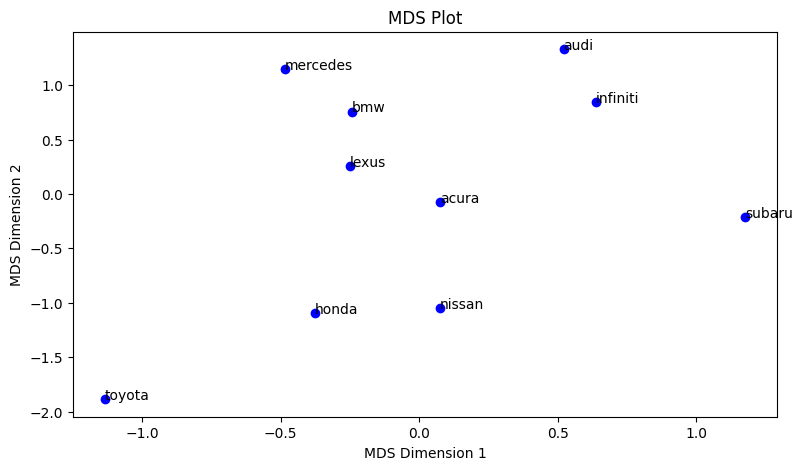

In [24]:
fig = plt.figure()
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(122)
t=top_10.set_index('Brand')
brands = t.index.tolist()
plt.scatter(X_transform[:,0], X_transform[:,1], c=['b'])
for i, txt in enumerate(brands):
    ax.annotate(txt, (X_transform[:,0][i], X_transform[:,1][i]))
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Plot')
fig.subplots_adjust(wspace=.2, hspace=0.5)

### Task E: Insights from Tasks C and D

#### Key Findings

**Competitive Landscape:** Based on the lift values, we can see that Honda, Toyota, and Nissan exhibit strong associations with each other, as indicated by lift values exceeding 2.3. In addition, Acura, Infiniti and Lexus are the luxury versions of Honda, Nissan and Toyota respectively, they all have lifts higher than 1.70. This suggests an overlap in their customer bases, highlighting the need for these brands to continually differentiate themselves to maintain market share.

**Consumer Preferences:** Audi and Mercedes share a lift value of approximately 2.5. This might suggest that customers perceive Audi vehicles as offering luxury and performance similar to Mercedes. Understanding these consumer preferences can guide product development and marketing strategies.

**Market Segmentation:** By considering these brand associations, we can identify distinct customer segments. Some consumers gravitate towards luxury brands like Audi and Mercedes, while others prefer more affordable options like Honda and Toyota. Recognizing these segments allows for targeted marketing efforts and tailored product offerings.

####  Business Suggestions

**Product Development:** Based on consumer preferences, we recommend that clients focus on enhancing the attributes associated with their brand. For example, if Lexus shares a strong luxury association with Mercedes, clients should prioritize the development of luxury features and performance in Lexus models to meet customer expectations.

**Marketing Strategies:** Brands can run targeted advertising campaigns that leverage the lift values to reach potential customers interested in similar products. For example, if Audi and Mercedes have a high lift value, they can create online ad campaigns that specifically target users who have shown interest in Mercedes vehicles. This strategy allows brands to tap into the existing customer base of their associated competitors without direct collaboration.

**Competitive Benchmarking:** Encourage clients to benchmark themselves against brands with similar associations. This benchmarking can reveal competitive strengths and weaknesses, aiding in pricing strategies, feature development, and market positioning.

**Customer Recommendations:** Utilize the lift values and consumer preferences to provide tailored recommendations to potential car buyers. For instance, customers associating Honda with Toyota may also prioritize a certain attribute shared by these brands. J.D. Power can recommend models with those attributes from both brands to cater to these specific customer preferences.

### Task F: Attributes Analysis

- Choose best 5 Attributes with the high Frequency counts
- Measure the association with top 5 brands (bmw, acura, audi, lexus, honda)

#### Identification of Top 5 Attributes

**The following are the attributes with the five highest frequency count:**

('performance', 658),
('price', 524),
('luxury', 522),
('engine', 437),
('interior', 379)

In [384]:
#creating list of all the words with their frequency
attribute_list=[]
def get_attribute(token_list):
    for i in token_list:
        attribute_list.append(i.lower())

comments['without_sw'].map(get_attribute)

#word frequency
attribute_counts=pd.Series(attribute_list).value_counts()
#exporting the word frequency to csv
pd.Series(attribute_list).value_counts().to_csv('attribute.csv')

In [380]:
from collections import defaultdict

top_5_brands=list(top_10[:5]['Brand'])
attributes=['performance','luxury','engine','price','interior']

co_occurrences = defaultdict(int)
max_distance = 50

for index, row in comments.iterrows():
    message = row['message'].lower() 
    words = message.split()  

    for brand in top_5_brands:
        for attribute in attributes:
            brand_indices = [i for i, word in enumerate(words) if brand in word]
            attribute_indices = [i for i, word in enumerate(words) if attribute in word]

            if any(abs(b - a) <= max_distance for b in brand_indices for a in attribute_indices):
                co_occurrences[(brand, attribute)] += 1

for (brand, attribute), count in co_occurrences.items():
    print(f"The brand '{brand}' and the attribute '{attribute}' co-occurred {count} times.")

The brand 'acura' and the attribute 'engine' co-occurred 51 times.
The brand 'acura' and the attribute 'price' co-occurred 46 times.
The brand 'lexus' and the attribute 'engine' co-occurred 44 times.
The brand 'lexus' and the attribute 'price' co-occurred 44 times.
The brand 'lexus' and the attribute 'interior' co-occurred 40 times.
The brand 'audi' and the attribute 'performance' co-occurred 41 times.
The brand 'audi' and the attribute 'engine' co-occurred 47 times.
The brand 'honda' and the attribute 'price' co-occurred 29 times.
The brand 'bmw' and the attribute 'performance' co-occurred 194 times.
The brand 'bmw' and the attribute 'engine' co-occurred 149 times.
The brand 'bmw' and the attribute 'luxury' co-occurred 124 times.
The brand 'bmw' and the attribute 'interior' co-occurred 90 times.
The brand 'audi' and the attribute 'luxury' co-occurred 38 times.
The brand 'audi' and the attribute 'interior' co-occurred 45 times.
The brand 'bmw' and the attribute 'price' co-occurred 176 

#### Brand-Attribute Association

In [381]:
attribute_series = pd.Series(attribute_list)

attribute_counts = attribute_series.value_counts()

attribute_frequencies_df = pd.DataFrame({'Attribute': attribute_counts.index, 'Count': attribute_counts.values})

attributes=['performance','luxury','engine','price','interior']

attribute_frequencies_df = attribute_frequencies_df[attribute_frequencies_df['Attribute'].isin(attributes)]

top_5_brands = top_10['Brand'][:5].tolist()
brand_counts = top_10.set_index('Brand')['Count'].to_dict()

attribute_counts = attribute_frequencies_df.set_index('Attribute')['Count'].to_dict()

total_messages = len(comments)

lift_values_df = pd.DataFrame(index=top_5_brands, columns=attributes)

for (brand, attribute), co_occur_count in co_occurrences.items():
    lift_value = (co_occur_count * total_messages) / (brand_counts[brand] * attribute_counts[attribute])
    lift_values_df.loc[brand, attribute] = lift_value

print(lift_values_df)

      performance  luxury  engine  price  interior
bmw      1.2785    1.0301  1.4786  1.9081  1.0298 
acura    1.0475    1.4253  1.2769  1.2582  1.0392 
lexus    0.9046    1.6249  1.4983  1.6369  1.5705 
honda    0.5577    0.8788  1.0147  1.1086  0.5245 
audi     0.9797    1.1446  1.6911  1.7689  1.8669 


#### Which attributes are most strongly associated with top 5 brands? (bmw, acura, audi, lexus, honda)

According to the lift values, the following attributes are highly associated with each of the brands:
- **Performance**: BMW (Lift = 1.28)
- **Luxury**: Lexus (Lift = 1.62)
- **Engine**: Audi (Lift = 1.69)
- **Price**: BMW (Lift = 1.91)
- **Interior**: Audi (Lift = 1.87)

### Task G: Advice Based on Task F

- Audi can be used as benchmarks for interior and engine attributes, while BMW can be used as benchmark for price, and Lexus can be used as a benchmark for Luxury, since they have higher associated lift values. In addition, brands can use this information to identify unique selling points (USPs) that set them apart from competitors. For example, since Audi has a relatively higher lift value for "interior" and "engine", it can use this as a strong selling point in its marketing.


- In order to improve the quality of their products, brands can focus on the attributes that have the lowest lift values. For example, Honda's performance attribute has the lowest lift which suggests that most people don't associate Honda with performance. As we observed earlier, people associate Honda with it's luxury version Acura (Lift 1.64) as a result, Honda can use Acura's performance as a benchmark and make improvements to their future models' accordingly.


- Over time, brands can track changes in these lift values to gauge shifts in customer perceptions. This can help them adapt their strategies to align with evolving consumer preferences.

### Task H: Aspirational Brand Analysis
#### Which is the most aspirational brand in your data in terms of people actually wanting to buy or own?
- Provide all details of your analysis – e.g., how you measured “aspirational” and how you found the most aspirational brand.
- What are the business implications for this brand?

#### Approach
To determine the most aspirational brand within our dataset, we followed a structured methodology that considered various factors related to brand desirability. Our approach can be broken down into several key steps:

 **1. Defining Aspirational Phrases:** 
 We employed ChatGPT to generate common expressions aligning with the aspirational sentiments of potential luxury-entry car buyers. We provided ChatGPT with 30 words from our original comment dataset, aiming to capture characteristics and sentiments typically associated with aspirational brands. This list served as the foundation for creating aspirational phrases. We also generated various verb tenses of these phrases to match them with the comments dataset as much as possible. Below is the list of the 30 words from the original dataset that we used for this purpose:

 ('like', 1711), ('get', 1266), ('think', 1170), ('best', 470), ('want', 644), ('buy', 501), ('great', 465), ('love', 250), ('regards', 225), ('buying', 175), ('worth', 161), ('choice', 148), ('especially', 146), ('consider', 121), ('wanted', 118), ('hope', 112), ('prefer', 107), ('thinking', 92), ('excellent', 85), ('decision', 79), ('soon', 77), ('fit', 74), ('liked', 73), ('purchase', 65), ('regardless', 61), ('cool', 61), ('advantage', 60), ('imagine', 50), ('wow', 48), ('prestige', 48).

 **2. Replacing Aspirational Phrases within the Comment Dataset with 'Aspirations':** 
 We systematically checked each comment for the presence of the defined aspirational phrases. If any were found, we replaced the aspirational phrase with the word 'aspirations' and updated the frequency count for that phrase. Below, we've presented the frequency of each aspirational phrase that was replaced with 'aspirations.'

 **3. Calculating Co-Occurrences of Brands and 'Aspirations':** 
 The top 5 brands were selected based on their highest frequency. Our rule considers two words (brands and 'aspirations') to co-occur if they appear within a maximum of 7 words of each other in a comment. By counting how often each brand appears near the word 'aspirations' within this rule, we generated a table that reveals the frequency of co-occurrences between each brand and 'aspirations.'

In [329]:
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter

# Assuming you have a DataFrame 'df' with a column named 'comments' containing your comments
# You can extract the comments as a list
Messages = comments['message'].tolist()

# define the aspiraitonal phrases
aspirational_phrases = [
    "consider purchase", "considered purchase", "considering purchase",
    "think about", "thought about", "thinking about",
    "want to buy", "wanted to buy", "wanting to buy",
    "best choice", "better choice", "best choices", "great choice", "greater choice", "great choices",
    "love to own", "loved to own", "loving to own",
    "seriously consider", "seriously considered", "seriously considering",
    "look to purchase", "looked to purchase", "looking to purchase",
    "plan to buy", "planned to buy", "planning to buy",
    "highly regard", "highly regarded", "highly regarding",
    "dream car", "dreamed of a car", "dreaming of a car",
    "worth buying", "worth bought", "worth buying",
    "hope to buy", "hoped to buy", "hoping to buy",
    "prefer option", "preferred option", "preferring option",
    "excellent choice", "excelled in choice", "excelling in choice", "excellent choices",
    "buy soon", "bought soon", "buying soon",
    "fit my lifestyle", "fitting my lifestyle", "fitted my lifestyle",
    "love the experience", "loved the experience", "loving the experience",
    "prestige vehicle", "prestigious vehicle", "prestige vehicles", "prestigious vehicles",
    "ready to purchase", "readied to purchase", "readying to purchase",
    "would love to", "would have loved to", "would love to", "would love",
    "wish to", "wished to", "wishing to",
    "desire to", "desired to", "desiring to",
    "dream of", "dreamed of", "dreaming of",
    "long for", "longed for", "longing for",
    "hope to", "hoped to", "hoping to",
    "plan on", "planned on", "planning on",
    "eager to", "eagered to", "eagering to",
    "consider getting", "considered getting", "considering getting",
    "aspire to", "aspired to", "aspiring to", "dreaming of owning", "dreamed of owning", "dreams of owning",
    "fantasize about", "fantasized about", "fantasizes about",
    "dreaming about", "dreamed about", "dreams about",
    "aim to purchase", "aimed to purchase", "aims to purchase",
    "craving to buy", "craved to buy", "craves to buy",
    "envision owning", "envisioned owning", "envisions owning",
    "fantasizing about", "fantasized about", "fantasizes about",
    "hoping to own", "hoped to own", "hopes to own",
    "longing to buy", "longed to buy", "longs to buy",
    "strive to own", "strived to own", "strives to own",
    "yearning for", "yearned for", "yearns for",
    "wish to acquire", "wished to acquire", "wishes to acquire",
    "yearn to drive", "yearned to drive", "yearns to drive",
    "crave to own", "craved to own", "craves to own",
    "aspiration to purchase", "aspired to purchase", "aspires to purchase",
    "aspiring to own", "aspired to own", "aspires to own",
    "covet to buy", "coveted to buy", "covets to buy",
    "desire to possess", "desired to possess", "desires to possess",
    "wishful thinking about", "wishful thinking about", "wishful thinking about",
    "goal to acquire", "goal to acquire", "goal to acquire",
    "wish to possess", "wished to possess", "wishes to possess",
    "anticipate owning", "anticipated owning", "anticipates owning",
    "fantasizing of owning", "fantasized of owning", "fantasizes of owning",
    "hoping to own", "hoped to own", "hopes to own",
    "aim to possess", "aimed to possess", "aims to possess",
    "strive to possess", "strived to possess", "strives to possess",
    "craving to possess", "craved to possess", "craves to possess",
    "envision owning", "envisioned owning", "envisions owning",
    "covet to drive", "coveted to drive", "covets to drive",
    "desire to own", "desired to own", "desires to own",
    "wishful thinking of", "wishful thinking of", "wishful thinking of",
    "goal to", "goal to", "goal to", "consider", "considered", "considering",
    "contemplate", "contemplated", "contemplating",
    "ponder", "pondered", "pondering",
    "mull over", "mulled over", "mulling over",
    "reflect on", "reflected on", "reflecting on",
    "ruminate on", "ruminated on", "ruminating on",
    "meditate on", "meditated on", "meditating on",
    "deliberate on", "deliberated on", "deliberating on",
    "dwell on", "dwelled on", "dwelling on",
    "consider the idea of", "considered the idea of", "considering the idea of",
    "contemplate the possibility of", "contemplated the possibility of", "contemplating the possibility of",
    "ponder the thought of", "pondered the thought of", "pondering the thought of",
    "mull over the notion of", "mulled over the notion of", "mulling over the notion of",
    "reflect on the concept of", "reflected on the concept of", "reflecting on the concept of",
    "ruminate on the idea of", "ruminated on the idea of", "ruminating on the idea of",
    "meditate on the prospect of", "meditated on the prospect of", "meditating on the prospect of",
    "deliberate on the decision to", "deliberated on the decision to", "deliberating on the decision to",
    "dwell on the thought of", "dwelled on the thought of", "dwelling on the thought of"
]

# Initialize a Counter to keep track of the total frequency of aspirational phrases
total_aspirational_freq = Counter()

# Iterate over comments
for i in range(len(Messages)):
    Message = Messages[i]
    
    # Tokenize the comment into words
    words = word_tokenize(Message.lower())
    
    # Iterate over aspirational phrases and replace them with 'aspirations'
    for phrase in aspirational_phrases:
        if phrase in Message.lower():
            Message = Message.replace(phrase, 'aspirations')
            
            # Update the frequency count for the replaced phrase
            total_aspirational_freq[phrase] += 1
    
    # Update the comment with replaced phrases
    Messages[i] = Message

# Create a DataFrame to store the updated comments
comments['Messages'] = Messages

# Display the frequency of each aspirational phrase (which all converted to 'aspirations')
for phrase, frequency in total_aspirational_freq.items():
    print(f"'{phrase}': {frequency} times")

# Save the updated DataFrame to a new CSV file if needed
df.to_csv('updated_comments.csv', index=False)

'thinking about': 17 times
'consider': 308 times
'plan on': 10 times
'looking to purchase': 1 times
'dream of': 3 times
'ponder': 3 times
'hope to': 9 times
'think about': 30 times
'great choice': 6 times
'would love to': 10 times
'desire to': 8 times
'wanting to buy': 2 times
'contemplating': 2 times
'hoping to': 6 times
'want to buy': 13 times
'long for': 7 times
'eager to': 2 times
'love to own': 2 times
'worth buying': 2 times
'considering': 6 times
'seriously consider': 8 times
'longing for': 1 times
'would have loved to': 1 times
'excellent choice': 1 times
'planning on': 6 times
'aspire to': 8 times
'highly regard': 1 times
'wanted to buy': 2 times
'best choice': 4 times
'planned on': 1 times
'longed for': 1 times
'better choice': 8 times
'would love': 4 times
'wish to': 8 times
'consider getting': 1 times
'thought about': 2 times
'dream car': 3 times
'yearned for': 1 times
'dwell on': 3 times
'desired to': 1 times
'wished to': 1 times
'plan to buy': 1 times


In [383]:
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter

# Assuming you have a DataFrame 'df' with a column named 'comments' containing your comments
# You can extract the comments as a list
Messages = comments['Messages'].tolist()

# Define the list of brands and the brand you're interested in (e.g., 'bmw')
brands = ['bmw', 'acura', 'audi', 'lexus', 'honda']

# Define the proximity limit
proximity_limit = 7

# Initialize a Counter to keep track of the frequency of co-occurrences
co_occurrence_freq = Counter()

# Process comments
for brand_of_interest in brands:
    for message in Messages:
        # Tokenize the comment into words
        words = word_tokenize(message.lower())

        # Find the positions of the brand mentions
        brand_positions = {brand: [i for i, word in enumerate(words) if word == brand] for brand in brands}

        # Find the positions of 'aspirations'
        aspirations_positions = [i for i, word in enumerate(words) if word == 'aspirations']

        # Check co-occurrence within proximity
        for brand, positions in brand_positions.items():
            for bp in positions:
                for ap in aspirations_positions:
                    distance = abs(bp - ap)
                    if distance <= proximity_limit:
                        co_occurrence_freq[(brand, 'aspirations')] += 1

# Create a DataFrame from the Counter
co_occurrence_df = pd.DataFrame.from_dict(co_occurrence_freq, orient='index', columns=['Frequency']).reset_index()
co_occurrence_df.rename(columns={'index': 'Brand-Aspirations Pair'}, inplace=True)

# Print the DataFrame
print(co_occurrence_df.sort_values(by='Frequency',ascending=False))

  Brand-Aspirations Pair  Frequency
0    (bmw, aspirations)      145   
1  (acura, aspirations)       35   
4  (lexus, aspirations)       25   
2   (audi, aspirations)       15   
3  (honda, aspirations)        5   


#### Findings:

Among the selected brands, 'BMW' emerges as the most aspirational brand with the highest frequency of co-occurrences with the word 'aspirations.' The high co-occurrence frequency of 'BMW' and 'aspirations' implies that BMW possesses a strong aspirational appeal among consumers. This appeal could be attributed to its brand image, features, or reputation in the entry level luxury sedan market.

#### Business Implications:
For BMW

 - BMW's slogan is "The Ultimate Driving Machine" which suggests that the makers of BMW believe that it has the finest performance and our analysis implies that in relative terms, BMW has the highest performance lift compared to the other most popular brands. However, since the lift value is very close to 1, people may have a neutral stance when it comes to associating BMW with performance. Given that it is a competitive landscape, BMW must proactively reinforce its position as a car with top of the line performance. Since performance is mostly associated with engine, BMW could use Audi as a benchmark for Audi shares the highest lift with 'engine' (lift value of 1.69). 


 - BMW, being the most aspirational brand in our analysis, can focus their marketing efforts on reaching aspirational buyers who value performance, luxury, and status. Collaborating with high-end lifestyle brands, sponsoring exclusive events or even endorsing talented celebrities who are known for being the best in their space can further reinforce its brand image. By strategically aligning with the top attributes, BMW can continue to attract and retain a loyal customer base while expanding its market reach.


 - We have also seen how price is an attribute that is strongly considered by people, it would be important for BMW to reinforce its high lift value for price (1.91) and focus on its pricing strategies. Consumers often associate aspirational brands with higher quality and prestige, allowing BMW to command premium prices for its vehicles. However, it's essential to strike a balance, ensuring that the pricing aligns with the perceived value. Businesses can use this aspirational status to justify premium pricing, but they should also consider offering a range of models and pricing options to cater to a broader customer base who want luxury at a more affordable price.


 - BMW can also focus on attributes that aren't strongly associated with them such as luxury, interior and engine (lowest lifts). By diving further into the key feautures that define these attributes, BMW can get a strong insight of what customers believe they lack in and make improvements accordingly. They can compare their attributes with the lowest lifts with the brands that have the highest ones and use those brands as benchmarks to make improvements to their products.